In [47]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, load_model,Model
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
# from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.layers import Flatten, Dense, Dropout,Conv2D,Activation,BatchNormalization,MaxPooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])

In [48]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [49]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
x_train = X_train.astype('float32')/255
x_test = X_test.astype('float32')/255
y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)

In [50]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [51]:
l2 = tf.keras.regularizers.l2(0.01)
params = {'activation': 'relu',
      'optimizer': 'Adam',
      'losses': 'categorical_crossentropy',
      'batch_size': 1500,
      'epochs': 60,
      'node_1' : 384,
      'node_2' : 256,
      'regularizers' :l2,
      'input_shape' :(32,32,3),
      'output_shape' : 10
    }
def create_model(params):
      net = VGG16(include_top=False, weights='imagenet', input_tensor=None,
              input_shape = (params['input_shape'])
              )
      
      # 透過layer_name 節取 model的某一層 block3_pool 
      layer_name='block3_pool'

      # 設定取到該層的都使用預設參數，不訓練參數
      layer_index=net.layers.index(net.get_layer(layer_name))
      
      # 建立模型
      base_model = net.get_layer(layer_name).output
  # base_model = tf.keras.layers.Conv2D(128, (1, 1), padding='valid')(base_model)
  # base_model = tf.keras.layers.MaxPooling2D( pool_size = (3, 3) )(base_model)
      # 攤平 feature map 
      base_model = Flatten()(base_model)

      base_model = Dropout(0.3)(base_model)
      base_model = tf.keras.layers.BatchNormalization()(base_model)
      base_model = Dense(units = params['node_1'], kernel_initializer = tf.keras.initializers.GlorotNormal()
                 ,kernel_regularizer= params['regularizers'] , activation= params['activation'])(base_model)


      base_model = Dense(units = params['node_2'], kernel_initializer = tf.keras.initializers.GlorotNormal()
                 ,kernel_regularizer = params['regularizers'] , activation= params['activation'])(base_model)

      base_model = Dropout(0.3)(base_model)
      output_layer = Dense(params['output_shape'], activation='softmax', name='softmax')(base_model)

      # 設定凍結與要進行訓練的網路層
      net_final = Model(inputs=net.input, outputs=output_layer)
      for layer in net_final.layers[:layer_index]:
          layer.trainable = False

      return net_final

In [52]:
model = create_model(params)
precision=tf.keras.metrics.Precision(name='precision')
recall=tf.keras.metrics.Recall(name='recall')
accuracy=tf.keras.metrics.CategoricalAccuracy(name='accuracy')
model.compile(optimizer=params['optimizer'],
        loss=params['losses'],
        metrics = [recall,precision,accuracy, f1_m],
        
        )


In [53]:
print(model.summary())

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)        

In [54]:
callbacks_list=[
  tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',mode='min', patience=20 ,restore_best_weights=True),
  tf.keras.callbacks.ModelCheckpoint(
            filepath='./C10_VGG16_01',
            monitor='val_loss',
            save_best_only=True),
  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                        patience=5,                      
                        verbose=1,
                        factor=0.3,  
                        min_lr=0.00001 )  
        ]


In [55]:
out = model.fit(
          x_train,y_train,
          validation_split=0.2,
          epochs=10,
          callbacks=callbacks_list               
            )

Epoch 1/10
1250/1250 [==============================] - 16s 12ms/step - loss: 3.2228 - recall: 0.4710 - precision: 0.7352 - accuracy: 0.6037 - f1_m: 0.5701 - val_loss: 1.5476 - val_recall: 0.5408 - val_precision: 0.8029 - val_accuracy: 0.6764 - val_f1_m: 0.6438
Epoch 2/10
1250/1250 [==============================] - 15s 12ms/step - loss: 1.4952 - recall: 0.5327 - precision: 0.7699 - accuracy: 0.6513 - f1_m: 0.6274 - val_loss: 1.2625 - val_recall: 0.6013 - val_precision: 0.8104 - val_accuracy: 0.7015 - val_f1_m: 0.6884
Epoch 3/10
1250/1250 [==============================] - 15s 12ms/step - loss: 1.3323 - recall: 0.5610 - precision: 0.7773 - accuracy: 0.6694 - f1_m: 0.6500 - val_loss: 1.1569 - val_recall: 0.6257 - val_precision: 0.8130 - val_accuracy: 0.7187 - val_f1_m: 0.7049
Epoch 4/10
1250/1250 [==============================] - 16s 12ms/step - loss: 1.2408 - recall: 0.5778 - precision: 0.7823 - accuracy: 0.6799 - f1_m: 0.6630 - val_loss: 1.0914 - val_recall: 0.6374 - val_precision: 0

In [14]:
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.fit(x_train, y_train, epochs=10, batch_size=64, verbose=1)

In [57]:
loss, accuracy, f1_score, precision, recall = model.evaluate(x_test, y_test)
print('Test:')
print('Loss:', np.round(loss, 4))
print('Accuracy: ', np.round(accuracy, 4))
print('Precision: ', np.round(precision, 4))
print('Recall: ', np.round(recall, 4))
print('F1 score: ', np.round(f1_score, 4))

313/313 [==============================] - 2s 7ms/step - loss: 1.0565 - recall: 0.6394 - precision: 0.8057 - accuracy: 0.7219 - f1_m: 0.7116
Test:
Loss: 1.0565
Accuracy:  0.6394
Precision:  0.7219
Recall:  0.7116
F1 score:  0.8057


In [63]:
loss, accuracy, f1_score, precision, recall = model.evaluate(x_train, y_train)
print('train:')
print('Loss:', np.round(loss, 4))
print('Accuracy: ', np.round(accuracy, 4))
print('Precision: ', np.round(precision, 4))
print('Recall: ', np.round(recall, 4))
print('F1 score: ', np.round(f1_score, 4))

1563/1563 [==============================] - 12s 7ms/step - loss: 0.9999 - recall: 0.6586 - precision: 0.8235 - accuracy: 0.7404 - f1_m: 0.7305
train:
Loss: 0.9999
Accuracy:  0.6586
Precision:  0.7404
Recall:  0.7305
F1 score:  0.8235


In [60]:
def show_train_history(out):    
    plt.plot(out.history["accuracy"])
    plt.plot(out.history["val_accuracy"])
    plt.title("Train History")
    plt.xticks(np.arange(10),np.arange(10).astype(str))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    
    fig=plt.gcf()
    fig.set_size_inches(16, 14)
    plt.subplot(221)
    plt.plot(out.history["loss"])
    plt.plot(out.history["val_loss"])
    plt.title("Train History")
    plt.xticks(np.arange(10),np.arange(10).astype(str))    
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["train", "validation"], loc="upper left")
    
    plt.subplot(222)
    plt.plot(out.history["f1_m"])
    plt.plot(out.history["val_f1_m"])
    plt.title("Train History")
    plt.xticks(np.arange(10),np.arange(10).astype(str))    
    plt.xlabel("Epoch")
    plt.ylabel("F1")
    plt.legend(["train", "validation"], loc="upper left")
    
    plt.subplot(223)
    plt.plot(out.history["precision"])
    plt.plot(out.history["val_precision"])
    plt.title("Train History")
    plt.xticks(np.arange(10),np.arange(10).astype(str))    
    plt.xlabel("Epoch")
    plt.ylabel("Precision")
    plt.legend(["train", "validation"], loc="upper left")
    
    plt.subplot(224)
    plt.plot(out.history["recall"])
    plt.plot(out.history["val_recall"])
    plt.title("Train History")
    plt.xticks(np.arange(10),np.arange(10).astype(str))    
    plt.xlabel("Epoch")
    plt.ylabel("Recall")
    plt.legend(["train", "validation"], loc="upper left")
    
    plt.show()

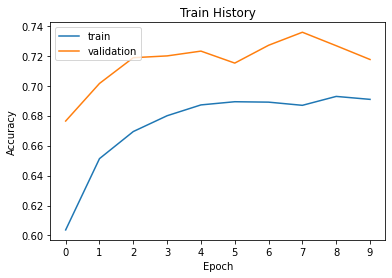

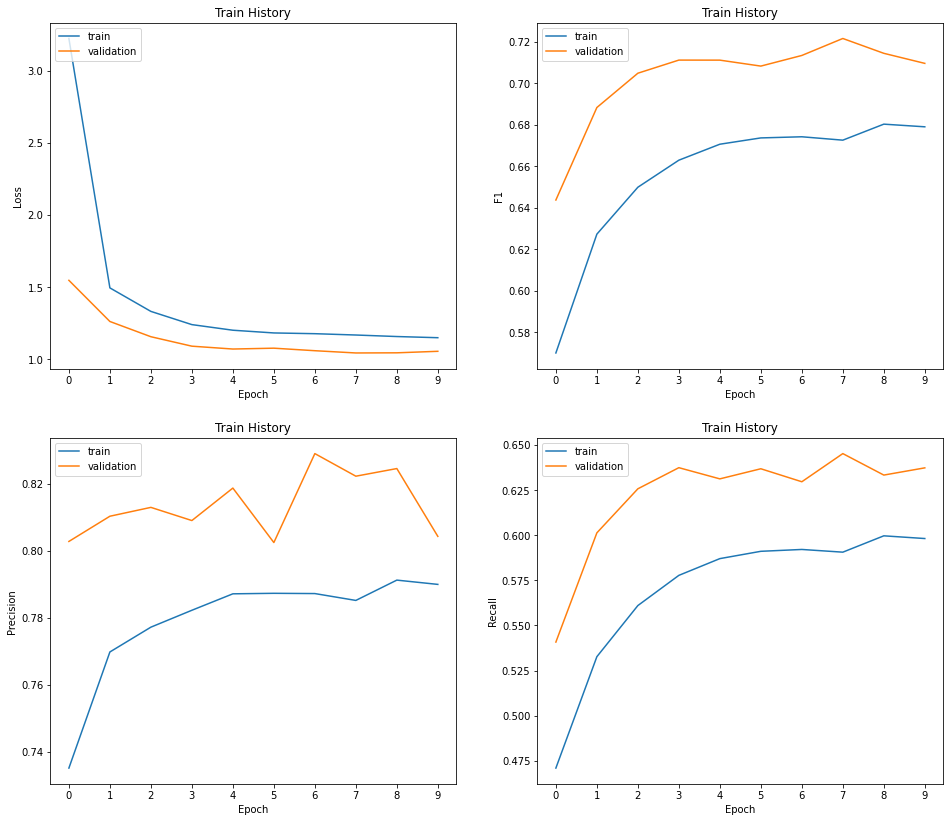

In [64]:
show_train_history(out) 